In [15]:
# importing libraries
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler
from sqlalchemy import create_engine

In [16]:
# Note:: The make sure you use the information from your specific PostgreSQL installation
host = r'127.0.0.1' # denotes that the db in a local installation
db = r'MSDS610' # db we just created
user = r'postgres' # using the postgres user for this demo
pw = r'pdahal001' # this is the password established during installation
port = r'5432' # default port estabalished during install

In [17]:
db_conn = create_engine("postgresql://{}:{}@{}:{}/{}".format(user, pw, host, port, db))

In [18]:
# Load the saved model and feature list
model = joblib.load("random_forest.pkl")
model_features = joblib.load("model_features.pkl")

In [19]:
# Function to prepare live data
def prepare_live_data(df):
    """
    Prepare live data for prediction using the same steps as training data
    """
    # Create a copy of the dataframe
    df_cleaned = df.copy()
    scaler = joblib.load('feature_scaler.pkl')
    
    # Drop irrelevant columns
    columns_to_remove = ["id", "name", "host_id", "host_name", "neighbourhood_group", "last_review"]
    df_cleaned = df_cleaned.drop(columns=columns_to_remove, axis=1)
    
    # Handle missing values
    df_cleaned["reviews_per_month"] = df_cleaned["reviews_per_month"].fillna(0)
    df_cleaned.dropna(inplace=True)
    
    # Feature engineering
    # 1. Availability ratio
    df_cleaned['availability_ratio'] = df_cleaned['availability_365'] / 365
    
    # 2. Review intensity score
    df_cleaned['review_intensity'] = df_cleaned['number_of_reviews'] * df_cleaned['reviews_per_month']
    
    # Normalize features
    scaler = MinMaxScaler()
    columns_to_normalize = ['minimum_nights', 'number_of_reviews', 'reviews_per_month', 'calculated_host_listings_count']
    df_cleaned[columns_to_normalize] = scaler.fit_transform(df_cleaned[columns_to_normalize])
    #df_cleaned[columns_to_normalize] = scaler.transform(df_cleaned[columns_to_normalize])
    # Convert categorical variables
    df_cleaned = pd.get_dummies(df_cleaned, columns=["room_type", "neighbourhood"], drop_first=True)
    
    # Ensure all features from training are present
    for feature in model_features:
        if feature not in df_cleaned.columns:
            df_cleaned[feature] = 0
            
    # Reorder columns to match training data
    df_cleaned = df_cleaned[model_features]
    
    return df_cleaned

This function prepares new Airbnb data for a prediction model by:

1. Cleaning: Removing irrelevant columns and handling missing values.

2. Engineering: Creating new features like availability ratio and review intensity.

3. Scaling: Normalizing numerical features.

4. Encoding: Converting categorical features to numerical ones.

5. Alignment: Ensuring the data matches the model's expected format.

In [20]:
def predict_prices(df):
    predictions = model.predict(df)
    # Remove the expm1 transformation if the model wasn't trained on log prices
    return predictions

In [21]:
# Main execution
if __name__ == "__main__":
    # Load live data
    live_data = pd.read_csv('live_data.csv')
    
    # Prepare the data
    prepared_data = prepare_live_data(live_data)
    
    # Generate predictions
    predictions = predict_prices(prepared_data)
    
    # Add predictions to original data
    live_data['predicted_price'] = predictions
    
    # Display results
    print("\nSample of predictions:")
    print(live_data[['id', 'room_type', 'neighbourhood', 'price', 'predicted_price']].head())
    
    # Calculate prediction metrics
    mae = np.mean(np.abs(live_data['price'] - live_data['predicted_price']))
    mape = np.mean(np.abs((live_data['price'] - live_data['predicted_price']) / live_data['price'])) * 100
    
    print(f"\nMean Absolute Error: ${mae:.2f}")
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")
    
    # Save results
    live_data.to_csv('predictions_output.csv', index=False)
    print("\nPredictions saved to 'predictions_output.csv'")



Sample of predictions:
         id        room_type    neighbourhood  price  predicted_price
0  40182247  Entire home/apt  Lower West Side    200       226.376516
1  45438479     Private room    Humboldt Park     44       147.232265
2  39793384     Private room    South Chicago     45       105.201177
3  35942729  Entire home/apt  Near North Side    255       182.931084
4   1468342     Private room  Grand Boulevard     55       110.751062

Mean Absolute Error: $65.88
Mean Absolute Percentage Error: 76.22%

Predictions saved to 'predictions_output.csv'


In [22]:
table_name = r'price_pred'
schema = r'analytics' 
live_data.to_sql(table_name, con=db_conn, if_exists='replace', index=False, schema=schema, chunksize=1000, method='multi')

100

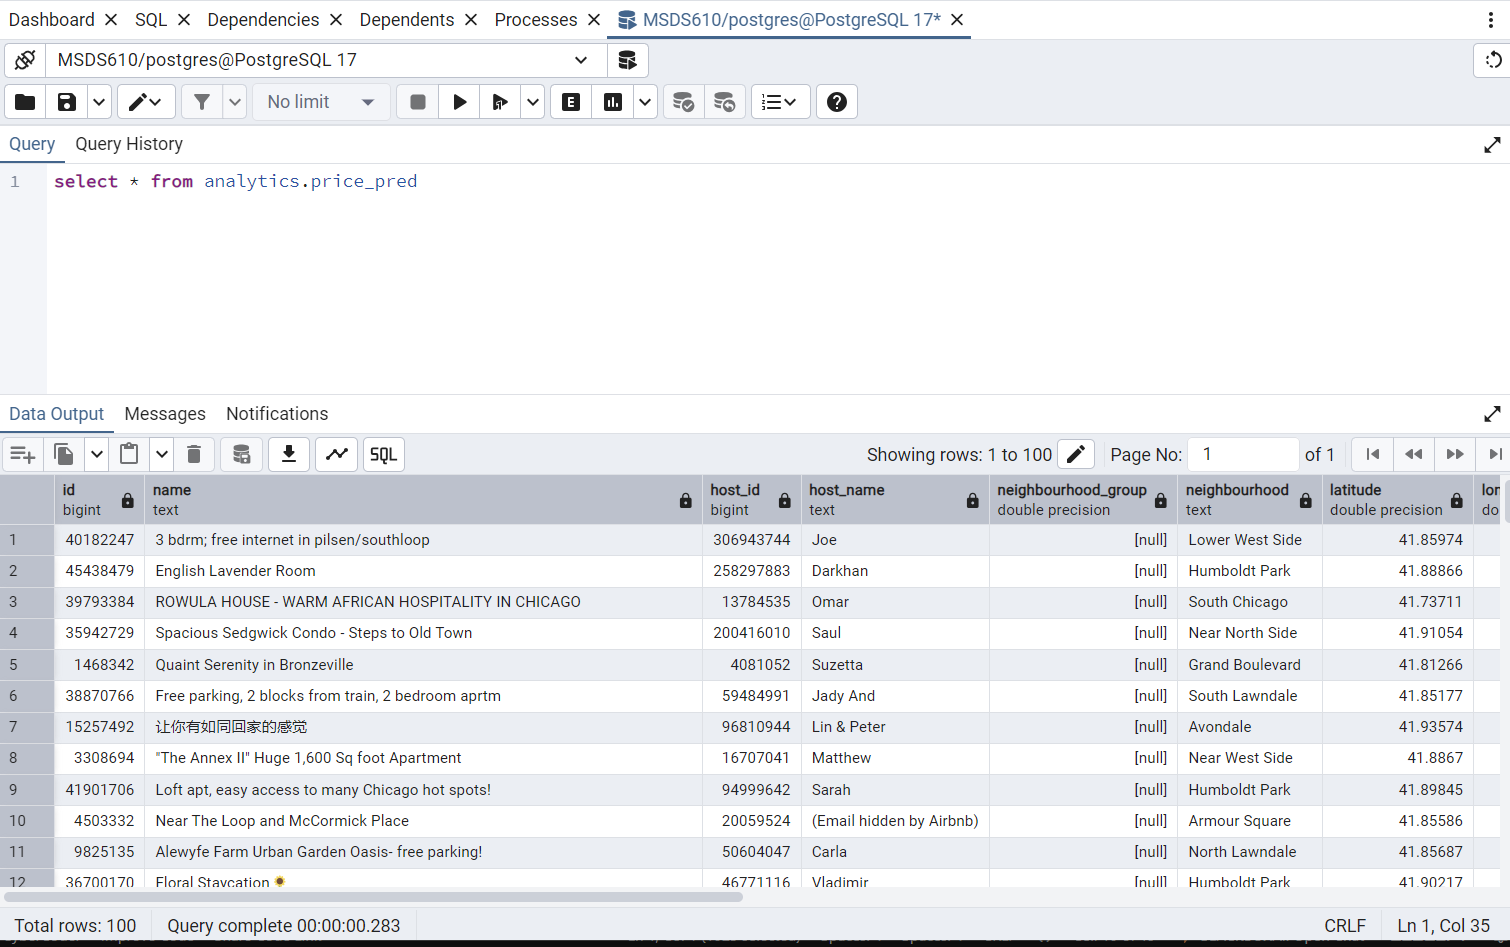

## Airbnb Price Prediction Results

**Overview:**

This section summarizes the results of an Airbnb price prediction process. The code took new listing information, cleaned it, used a prediction model to estimate prices, and then evaluated the model's accuracy.

* **Observation:** The model's predictions vary in accuracy.
    * For example, listing ID 40182247 had a relatively close prediction ($226.38 predicted vs. $200 actual).
    * However, listing ID 45438479 showed a significant overestimation ($147.23 predicted vs. $44 actual).

**Error Metrics:**

* **Mean Absolute Error (MAE): $65.88**
    * This means, on average, the model's predictions were off by approximately $65.88.
* **Mean Absolute Percentage Error (MAPE): 76.22%**
    * This indicates that, on average, the predictions were off by 76.22% of the actual price, signifying low accuracy.

**Summary:**

The prediction model generated price estimates, but the high MAPE value (76.22%) indicates that the predictions were not very accurate. There is a substantial average difference between the actual and predicted prices.









# Visualization and Insights

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

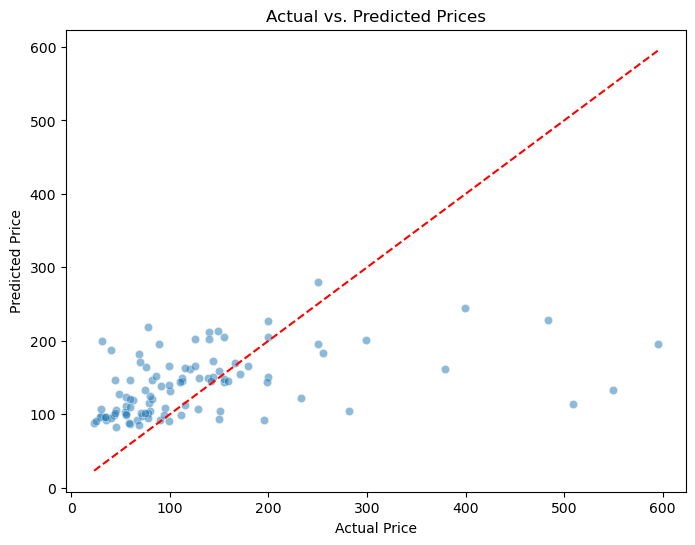

In [24]:
# Scatter Plot: Actual vs. Predicted Prices
plt.figure(figsize=(8,6))
sns.scatterplot(x=live_data['price'], y=live_data['predicted_price'], alpha=0.5)
plt.plot([live_data['price'].min(), live_data['price'].max()], 
         [live_data['price'].min(), live_data['price'].max()], 
         color='red', linestyle='--')  # Ideal line y=x
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual vs. Predicted Prices")
plt.show()

At first glance, it seems like my model is doing a decent job, especially for those budget-friendly places. The predicted prices are lining up pretty well with the actual ones. But here's the thing: it starts to get a bit shaky when we look at the higher-end properties. Seems like I'm having some trouble getting those predictions spot-on. So, if we're thinking of going for a luxury apartment or a larger house, we might need to do some more digging and fine-tuning to make sure we're pricing things right.  It's not a complete miss, but there's definitely room for improvement!

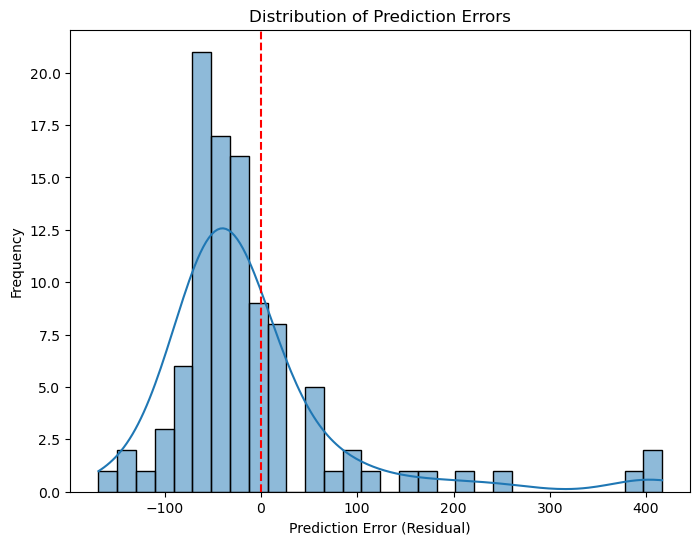

In [25]:
# Calculate residuals
residuals = live_data['price'] - live_data['predicted_price']

# Histogram of Residuals
plt.figure(figsize=(8,6))
sns.histplot(residuals, bins=30, kde=True)
plt.axvline(x=0, color='red', linestyle='--')
plt.xlabel("Prediction Error (Residual)")
plt.ylabel("Frequency")
plt.title("Distribution of Prediction Errors")
plt.show()

Looking at this histogram, I can see how well my model is predicting Airbnb prices by analyzing the distribution of errors. The big peak near zero is reassuring because it means a lot of my predictions are pretty close to the actual prices. But the spread of bars on both sides shows where the model is making mistakes. The negative errors tell me that I’ve been overestimating prices, while the positive errors mean I’ve been underestimating. The red line, which represents the average error, leans slightly to the left, suggesting that my model tends to overprice listings. What really concerns me, though, is the wide range of errors—some are over $100 off in either direction, which tells me my predictions aren’t consistently accurate. If I’m overpricing larger properties, I could be scaring away potential guests. While the model gives me a solid starting point, I know I can’t rely on it blindly. 

# Summary

The model performs well for budget-friendly listings, with predicted prices closely aligning with actual values. However, its accuracy declines for higher-end properties, indicating the need for further fine-tuning, particularly for luxury listings or larger homes.

While the model provides a solid starting point for Airbnb price predictions, its current accuracy is insufficient for precise pricing decisions. The high prediction errors, especially for high-value properties, suggest the need for improvements. Future enhancements could include:

- **Refining feature selection and data preprocessing.**  
- **Experimenting with alternative machine learning models.**  
- **Incorporating additional variables** such as seasonality, demand trends, and property amenities.  

For now, the model offers general price estimates, but **manual adjustments and further fine-tuning** are essential for more reliable Airbnb pricing strategies.


# Reflection

During the course of this project, I encountered several challenges, particularly in data cleaning and feature engineering. Preparing the data required removing irrelevant columns, handling missing values, and creating meaningful features to improve model performance. One of the biggest challenges was ensuring that the data was properly transformed and normalized to feed it into the Random Forest Regressor model. Additionally, optimizing the model by tuning hyperparameters and performing a 3-way split was a critical step that tested my understanding of model evaluation.

One aspect I particularly enjoyed was the process of feature engineering, where I created new variables like 'availability_ratio', 'seasonality_score' and 'review_intensity_score'. It was interesting to see how these features influenced the model’s predictive power. Additionally, deploying the model and writing user-defined functions (UDFs) to make predictions on live data was a new and exciting experience for me. This step helped me understand how models transition from development to production and the importance of making them adaptable to real-time data.

Through this project, I gained a much better understanding of the entire machine learning pipeline — from data preparation, feature engineering, and model training to deployment. I also realized the importance of model evaluation and the need to optimize for performance. Overall, the project provided me with hands-on experience in deploying a machine learning model, and I feel more confident in my ability to apply these skills in real-world scenarios.